# Chapter 11 - Attention Mechanisms and Transformers

The core idea behind the Transformer model is the *attention mechanism*, an innovation that was originally envisioned as an enhancement for encoder-decoder RNNs applied to sequence-to-sequence applications.

## 11.1. Queries, Keys, and Values

In the simplest databases $\mathcal{D}$, they are collections of keys ($k$) and values ($v$). The keys are used to look up the values. We can operate on $\mathcal{D}$ with the exact query ($q$) for a key $k$ to retrieve the corresponding value $v$. If the key $k$ is not a record in $\mathcal{D}$, there would be no valid answer.
* We can design queries $q$ that operate on $(k, v)$ pairs in such a manner as to be valid regardless of the database size.
* The same query can receive different answers, according to the contents of the database.
* The "code" being executed for operating on a large state space (the database) can be quite simple (e.g., exact match, approximate match, top-$k$).
* There is no need to compress or simplify the database to make the operations effective.

In the context of deep learning, consider to denote by $\mathcal{D} \stackrel{\textrm{def}}{=} \{(\mathbf{k}_1, \mathbf{v}_1), \ldots (\mathbf{k}_m, \mathbf{v}_m)\}$ a database of $m$ tuples of *keys* and *values*. Moreover, denote by $\mathbf{q}$ a *query*. Then, we can define the ***attention*** over $\mathcal{D}$ as
\begin{split}
\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,
\end{split}
where $\alpha(\mathbf{q}, \mathbf{k}_i)\in\mathbb{R}$ ($i=1,\ldots,m$) are scalar attention weights. This operation is referred to as *attention pooling*. The attention over $\mathcal{D}$ generates a linear combination of values contained in the database. Special cases of attention pooling are:
* The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ are nonnegative. The output of the attention mechanism in this case is contained in the convex cone spanned by the value vectors $\mathbf{v}_i$.
* The weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ form a convex combination, i.e., $\sum_i \alpha(\mathbf{q}, \mathbf{k}_i) = 1$ and $\alpha(\mathbf{q}, \mathbf{k}_i) \geq 0$ for all $i$. This is the most common case in deep learning.
* Exactly one of the weights $\alpha(\mathbf{q}, \mathbf{k}_i)$ is 1, while all others are 0. This is akin to a traditional database query.
* All weights are equal, i.e., $\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{1}{m}$ for all $i$. This amounts to averaging across the entire database, also called average pooling in deep learning.

Normalization to ensure that the weights sum up to 1:
\begin{split}
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{{\sum_j} \alpha(\mathbf{q}, \mathbf{k}_j)}
\end{split}

To ensure that the weights are also nonnegative, we can resort to exponentiation, which means that we can now pick *any* function $\alpha(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it:
\begin{split}
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}
\end{split}

The figure below illustrates the attention mechanism computing a linear combination over value vectors via attention pooling.

![](../imgs/ch11/qkv.svg)

In [1]:
import torch
from d2l import torch as d2l

### 11.1.1. Visualization

When the weights are nonnegative and sum to 1, we may interpret large weights as a way for the model to select components of relevance. We can visualize its effect on the given set of keys when applying a variety of different queries.

The `show_heatmaps` function below takes a tensor with 4 axes, allowing for an array of different queries and weights. The input `matrices` has the shape (number of rows for display, number of columns for display, number of queries, number of keys).

In [2]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(3,3), cmap='Reds'):
    '''Show heatmaps of matrices'''
    d2l.use_svg_display() # Use svg format to display plots in jupyter

    # matrices should be a 4D tensor
    num_rows, num_cols, _, _ = matrices.shape

    fig, axes = d2l.plt.subplots(
        num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False
    )

    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)

            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])

    fig.colorbar(pcm, ax=axes, shrink=0.6);

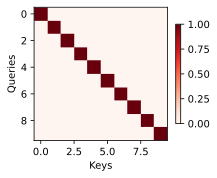

In [3]:
# prepare a toy 4D attention matrix
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 11.2. Attention Pooling by Similarity

The attention mechanism can also be used in the kernel density estimation. In this case, the estimators rely on some similarity kernel $\alpha(\mathbf{q}, \mathbf{k})$ relating queries $\mathbf{q}$ and keys $\mathbf{k}$. Some common kernels are
\begin{split}\begin{aligned}
\alpha(\mathbf{q}, \mathbf{k}) & = \exp\left(-\frac{1}{2} \|\mathbf{q} - \mathbf{k}\|^2 \right) && \textrm{Gaussian;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = 1 \textrm{ if } \|\mathbf{q} - \mathbf{k}\| \leq 1 && \textrm{Boxcar;} \\
\alpha(\mathbf{q}, \mathbf{k}) & = \mathop{\mathrm{max}}\left(0, 1 - \|\mathbf{q} - \mathbf{k}\|\right) && \textrm{Epanechikov.}
\end{aligned}\end{split}
The kernels are sometimes called *Parzen windows* or *Nadaraya-Watson kernels*. All of the kernels are heuristic and can be tuned. All of them lead to the following eqaution for regression and classification alike:
\begin{split}
f(\mathbf{q}) = \sum_i \mathbf{v}_i \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}.
\end{split}

In the case of a (scalar) regression with observations $(\mathbf{x}_i, y_i)$ for features and labels, respectively, $\mathbf{v}_i=y_i$ are scalars, $\mathbf{k}_i = \mathbf{x}_i$ are feature vectors, and the query $\mathbf{q}$ denotes the new location where $f$ should be evaluated.

In the case of (multiclass) classification, we use one-hot-encoding of $y_i$ to obtain $\mathbf{v}_i$. Since these estimators require no training, we can narrow the kernels with increasing amounts of data. It will converge to some statistical optimal solution.

In [4]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from d2l import torch as d2l

d2l.use_svg_display()

### 11.2.1. Kernels and Data

All the kernels $\alpha(\mathbf{q}, \mathbf{k})$ defined in this section are *translation and rotation invariant*, that is, if we shift and rotate $\mathbf{q}$ and $\mathbf{k}$ in the same manner, the value of $\alpha$ remains unchanged.

For simplicity we pick scalar arguments $k, q\in\mathbb{R}$ and pick the key $k=0$ as the origin.

In [5]:
# define kernels
def gaussian(x):
    return torch.exp(-x ** 2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

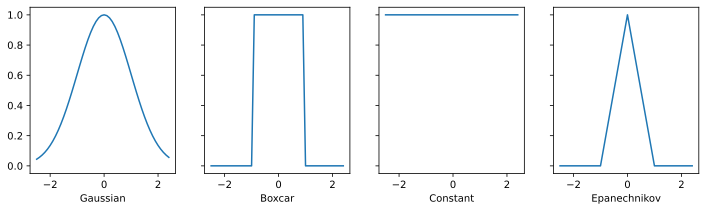

In [6]:
fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechnikov')
x = torch.arange(-2.5, 2.5, 0.1)

for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

Different kernels correspond to different notions of range and smoothness. For instance, the boxcar kernel only attends to observations within a distance of 1 and does so indiscriminately.

To apply Nadaraya-Watson estimation, we need to define some training data. We use the following function to generate the data:
\begin{split}
y_i = 2\sin(x_i) + x_i + \epsilon,
\end{split}
where $\epsilon$ is drawn from a normal distribution with zero mean and unit variance.

In [7]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5) # Training inputs
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1) # Validation inputs
y_val = f(x_val)

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(torch.Size([40]), torch.Size([40]), torch.Size([50]), torch.Size([50]))

### 11.2.2. Attention Pooling via Nadaraya-Watson Regression

After we created the training data and defined the kernels, we need a function to compute the kernel regression estimates. We also want to obtain the relative kernel weights in order to perform minor diagnostics. Hence, we compute the kernel between all training features (covariates) `x_train` and all validation features `x_val` first. This gives a matrix, which we subsequently normalize. When multiplied with the training labels `y_train`, we obtain the estimates.

Recall the attention pooling from the beginning of this section:
\begin{split}
\textrm{Attention}(\mathbf{q}, \mathcal{D}) \stackrel{\textrm{def}}{=} \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,
\end{split}
Let each validation feature be a query, and each training feature-label pair be a key-value pair. As a result, the normalized relative kernel weights (`attention_w` below) are the *attention weights*.

In [15]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    # reshape x_train to (len(x_train), 1)
    x_train = x_train.reshape((-1, 1))
    # reshape x_val to (1, len(x_val))
    x_val = x_val.reshape((1, -1))
    # compute the difference between each element in x_val and x_train
    # dists.shape = (len(x_train), len(x_val))
    dists = x_train - x_val

    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)

    # normalization over keys for each query
    attention_w = k / k.sum(0)
    # attention_w.shape = (len(x_train), len(x_val))

    y_hat = y_train @ attention_w
    return y_hat, attention_w

In [16]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)

        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);

        ax.set_xlabel(name)

        if not attention:
            ax.legend(['y_hat', 'y'])

    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

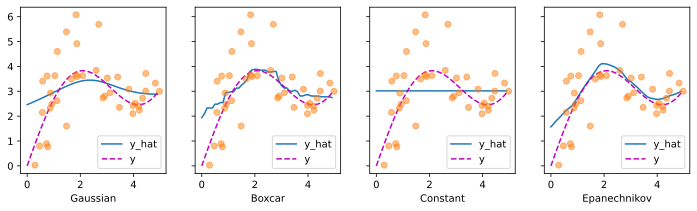

In [17]:
# check different kernels
plot(x_train, y_train, x_val, y_val, kernels, names, attention=False)

Gaussian, Boxcar and Epanechikov kernels produce fairly workable estimates that are not too far from the true funciton. Only the constant kernel produces a rather unrealistic result due to the fact that it does not use the features at all.

We can also inspectr the attention weighting:

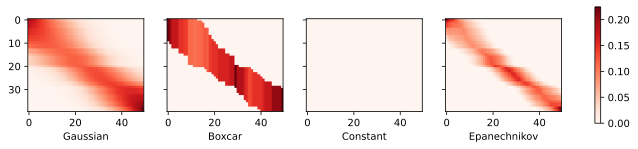

In [18]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The visualization shows that the attention weights for Gaussian, Boxcar, and Epanechikov kernels are very similar since they are derived from very similar attention weights, despite the different functional form of the kernels.

### 11.2.3. Adapting Attention Pooling

We could replace the Gaussian kernel with a different width that we could use $\alpha(\mathbf{q}, \mathbf{k}) = \exp\left(-\frac{1}{2 \sigma^2} \|\mathbf{q} - \mathbf{k}\|^2 \right)$ where $\sigma^2$ determines the width of the kernel.

In [19]:
def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

In [20]:
sigmas = (0.1, 0.2, 0.5, 1.)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

kernels = [gaussian_with_width(sigma) for sigma in sigmas]

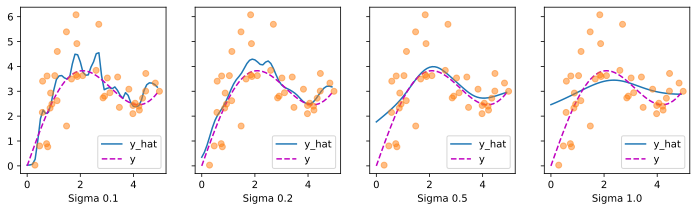

In [21]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=False)

The narrower the kernel, the less smooth the estimate. In addition, it adapts better to the local variations.

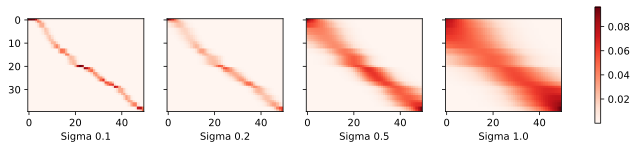

In [22]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The narrower the kernel, the narrower the range of large attention weights. Picking the same width may not be ideal.

## 11.3. Attention Scoring Functions